# Imports, Reproducibility, and GPU Setup

In [2]:
import os
import glob
import random
import json
from pathlib import Path
from collections import Counter, defaultdict
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

# GPU configuration for RTX 4060
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth so TF doesn't grab all VRAM
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("WARNING: No GPU detected. Training will be slow.")

# Reproducibility (as much as TF allows)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


TensorFlow version: 2.10.1
1 Physical GPUs, 1 Logical GPUs


# Paths and Global Hyperparameters

In [3]:
# Base directory where ODIR npz data resides
BASE_DIR = r"E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

print("Train dir:", TRAIN_DIR)
print("Val dir  :", VAL_DIR)
print("Test dir :", TEST_DIR)

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

NUM_EPOCHS = 25
RESULTS_DIR = "./results_odir_dr_tf"
os.makedirs(RESULTS_DIR, exist_ok=True)


Train dir: E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\train
Val dir  : E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\val
Test dir : E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\test


# List .npz Files and Inspect Structure

In [4]:

def list_npz_files(split_dir):
    files = sorted(glob.glob(os.path.join(split_dir, "*.npz")))
    print(f"{split_dir}: found {len(files)} .npz files")
    return files

train_files = list_npz_files(TRAIN_DIR)
val_files   = list_npz_files(VAL_DIR)
test_files  = list_npz_files(TEST_DIR)

# Quick peek at one file
sample_path = train_files[0] if train_files else None
if sample_path:
    sample_npz = np.load(sample_path, allow_pickle=True)
    print("Keys in sample npz:", list(sample_npz.keys()))
    for k in sample_npz.keys():
        arr = np.array(sample_npz[k])
        print(f"  {k}: type={type(sample_npz[k])}, shape={arr.shape}, dtype={arr.dtype}")


E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\train: found 4476 .npz files
E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\val: found 641 .npz files
E:\Phd\2-Fall 2025\Data Mining 566\Final Project\Dataset\ODIR_Data-20251116T075224Z-1-001\ODIR_Data\test: found 1914 .npz files
Keys in sample npz: ['slo_fundus', 'race', 'male', 'hispanic', 'maritalstatus', 'language', 'dr_class', 'dr_subtype']
  slo_fundus: type=<class 'numpy.ndarray'>, shape=(200, 200, 3), dtype=uint8
  race: type=<class 'numpy.ndarray'>, shape=(), dtype=int64
  male: type=<class 'numpy.ndarray'>, shape=(), dtype=int64
  hispanic: type=<class 'numpy.ndarray'>, shape=(), dtype=int64
  maritalstatus: type=<class 'numpy.ndarray'>, shape=(), dtype=int64
  language: type=<class 'numpy.ndarray'>, shape=(), dtype=int64
  dr_class: type=<class 'numpy.ndarray'>, shape=(), dtype=int64
  dr_subtype: type=<class 'numpy.ndarray'

# Visualization: Sample Fundus Images and Label Distribution


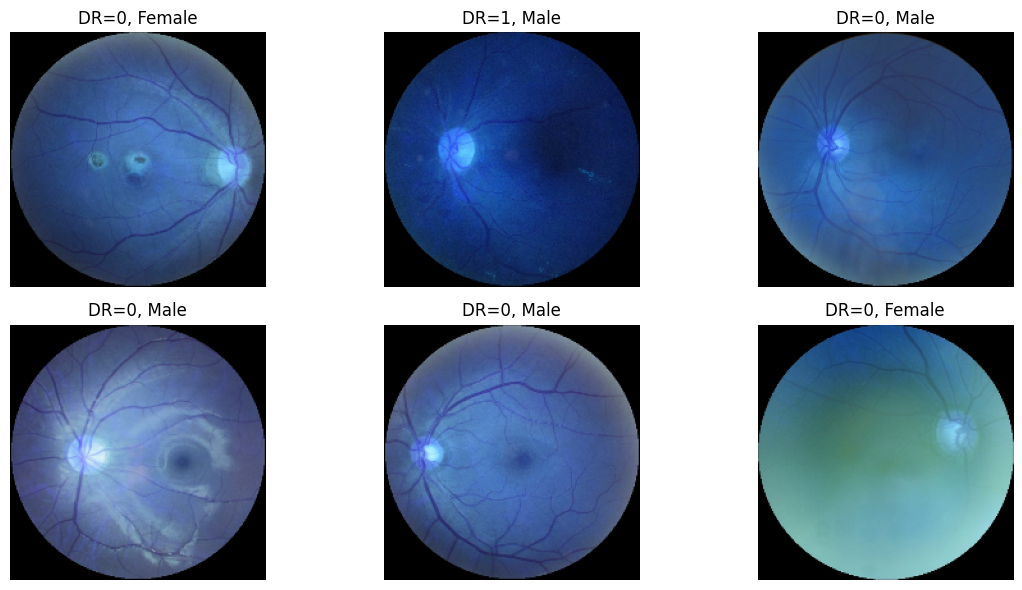

In [ ]:
# %Visualization: Sample Fundus Images and Label Distribution%
def load_sample_npz(path):
    data = np.load(path, allow_pickle=True)
    img = data["slo_fundus"]
    dr_class = int(data["dr_class"])
    male = int(data["male"])  # 1=male, 0=female (assuming)
    return img, dr_class, male

def to_rgb(img):
    img = np.array(img)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    elif img.ndim == 3 and img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    img = img.astype(np.float32)
    img_min, img_max = img.min(), img.max()
    if img_max > img_min:
        img = (img - img_min) / (img_max - img_min)
    return img

n_show = min(6, len(train_files))
plt.figure(figsize=(12, 6))
for i, path in enumerate(random.sample(train_files, n_show)):
    img, dr_cls, male = load_sample_npz(path)
    rgb = to_rgb(img)
    plt.subplot(2, 3, i+1)
    plt.imshow(rgb)
    plt.axis('off')
    sex_str = "Male" if male == 1 else "Female"
    plt.title(f"DR={dr_cls}, {sex_str}")
plt.tight_layout()
plt.show()


# Class Imbalance: Class Weights

Train set size: 4476
DR class distribution (train): Counter({0: 3358, 1: 1118})
Gender distribution (train): Counter({1: 2390, 0: 2086})


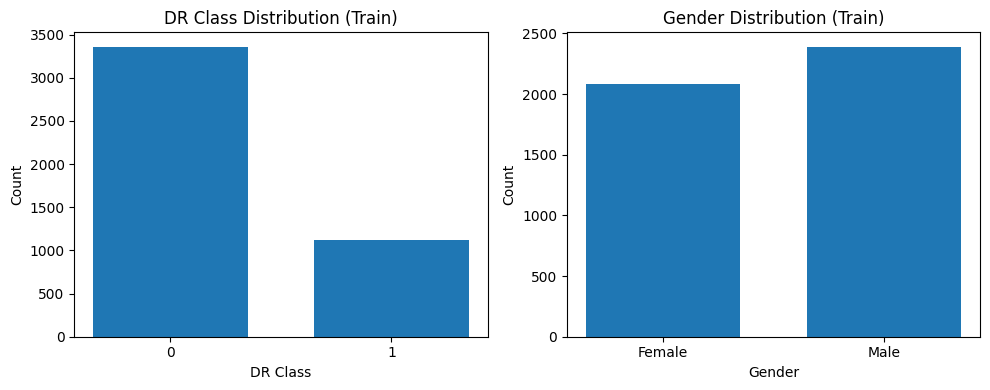

In [ ]:
# Class Imbalance: Class Weights
def compute_label_stats(file_list):
    labels = []
    genders = []
    for path in file_list:
        data = np.load(path, allow_pickle=True)
        labels.append(int(data["dr_class"]))
        genders.append(int(data["male"]))
    return np.array(labels), np.array(genders)

train_labels, train_genders = compute_label_stats(train_files)
print("Train set size:", len(train_labels))
print("DR class distribution (train):", Counter(train_labels))
print("Gender distribution (train):", Counter(train_genders))

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist(train_labels, bins=np.arange(-0.5, 2.5, 1), rwidth=0.7)
axs[0].set_xticks([0,1])
axs[0].set_xlabel("DR Class")
axs[0].set_ylabel("Count")
axs[0].set_title("DR Class Distribution (Train)")

axs[1].hist(train_genders, bins=np.arange(-0.5, 2.5, 1), rwidth=0.7)
axs[1].set_xticks([0,1])
axs[1].set_xticklabels(["Female", "Male"])
axs[1].set_xlabel("Gender")
axs[1].set_ylabel("Count")
axs[1].set_title("Gender Distribution (Train)")
plt.tight_layout()
plt.show()


In [7]:
# %%
class_counts = Counter(train_labels)
print("Class counts (train):", class_counts)

num_samples = len(train_labels)
class_weights = {c: num_samples / (len(class_counts) * cnt) for c, cnt in class_counts.items()}
print("Class weights:", class_weights)

# For Keras, we need mapping from class index to weight:
keras_class_weights = {0: float(class_weights.get(0, 1.0)),
                       1: float(class_weights.get(1, 1.0))}
keras_class_weights


Class counts (train): Counter({0: 3358, 1: 1118})
Class weights: {0: 0.6664681357951161, 1: 2.001788908765653}


{0: 0.6664681357951161, 1: 2.001788908765653}

In [8]:
# %%
def npz_generator(file_paths):
    for path in file_paths:
        data = np.load(path, allow_pickle=True)
        img = data["slo_fundus"]
        label = int(data["dr_class"])
        gender = int(data["male"])
        
        img = np.array(img)
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.ndim == 3 and img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)
        
        img = img.astype(np.float32)
        yield img, label, gender, os.path.basename(path)

output_signature = (
    tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),  # image HxWx3
    tf.TensorSpec(shape=(), dtype=tf.int32),                 # label
    tf.TensorSpec(shape=(), dtype=tf.int32),                 # gender
    tf.TensorSpec(shape=(), dtype=tf.string)                 # id
)

train_ds_raw = tf.data.Dataset.from_generator(
    lambda: npz_generator(train_files),
    output_signature=output_signature
)
val_ds_raw = tf.data.Dataset.from_generator(
    lambda: npz_generator(val_files),
    output_signature=output_signature
)
test_ds_raw = tf.data.Dataset.from_generator(
    lambda: npz_generator(test_files),
    output_signature=output_signature
)


# Preprocessing & Augmentation Functions

In [9]:
# %%
IMG_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMG_STD  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

def preprocess_image(img):
    # img: float32, arbitrary size, 3 channels, values ~ 0..max
    # scale to 0..1
    img_min = tf.reduce_min(img)
    img_max = tf.reduce_max(img)
    img = tf.cond(
        img_max > img_min,
        lambda: (img - img_min) / (img_max - img_min),
        lambda: img
    )
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def augment_image(img):
    # simple augmentations to avoid heavy CPU overhead
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img

def normalize_image(img):
    # assume img 0..1, convert to (x - mean)/std
    img = (img - IMG_MEAN) / IMG_STD
    return img

# Preprocessing helpers unchanged:
# preprocess_image(img), augment_image(img), normalize_image(img)

def train_map_fn(img, label, gender, sample_id):
    img = preprocess_image(img)
    img = augment_image(img)
    img = normalize_image(img)
    label = tf.cast(label, tf.float32)
    # RETURN ONLY (x, y) for training
    return img, label

def eval_map_fn(img, label, gender, sample_id):
    img = preprocess_image(img)
    img = normalize_image(img)
    label = tf.cast(label, tf.float32)
    # RETURN ONLY (x, y) for validation
    return img, label

# For TEST we keep metadata so we can compute per-gender metrics:
def test_map_fn(img, label, gender, sample_id):
    img = preprocess_image(img)
    img = normalize_image(img)
    label = tf.cast(label, tf.float32)
    gender = tf.cast(gender, tf.int32)
    # We pack metadata in a tuple; not used for training, only evaluation
    return img, (label, gender, sample_id)



# tf.data Pipelines

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds_raw, map_fn, batch_size=BATCH_SIZE, training=False):
    ds = ds_raw.map(map_fn, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds_raw, train_map_fn, training=True)
val_ds   = prepare_dataset(val_ds_raw,   eval_map_fn,  training=False)

# Test dataset uses the special test_map_fn
test_ds = test_ds_raw.map(test_map_fn, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Sanity check
for images, labels in train_ds.take(1):
    print("Train batch X shape:", images.shape)
    print("Train batch y shape:", labels.shape)
    break

for images, meta in test_ds.take(1):
    labels, genders, ids = meta
    print("Test batch X shape:", images.shape)
    print("Test labels shape:", labels.shape)
    print("Test genders shape:", genders.shape)
    print("Test ids shape:", ids.shape)
    break


Train batch X shape: (32, 224, 224, 3)
Train batch y shape: (32,)
Test batch X shape: (32, 224, 224, 3)
Test labels shape: (32,)
Test genders shape: (32,)
Test ids shape: (32,)


# Metric & Loss Setup

In [ ]:
# Metric & Loss Setup
# Keras metrics for training
train_metrics = [
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Recall(name="recall"),
    
]

val_metrics = [
    keras.metrics.AUC(name="auc"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Recall(name="recall"),
]

loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)


# Model Builders: EfficientNetB0 & DenseNet121

In [ ]:
# Model Builders: EfficientNetB0 & DenseNet121
from tensorflow.keras.applications import EfficientNetB0, DenseNet121

def build_efficientnet_b0_model():
    base = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling="avg"
    )
    x = base.output
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation="sigmoid", name="output")(x)
    model = keras.Model(inputs=base.input, outputs=output, name="EfficientNetB0_DR")
    return model

def build_densenet121_model():
    base = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling="avg"
    )
    x = base.output
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation="sigmoid", name="output")(x)
    model = keras.Model(inputs=base.input, outputs=output, name="DenseNet121_DR")
    return model

effnet = build_efficientnet_b0_model()
densenet = build_densenet121_model()

effnet.summary()


Model: "EfficientNetB0_DR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0

# Compile, Callbacks, and Training Function

In [ ]:
# Compile, Callbacks, and Training Function
def compile_model(model, lr=1e-4):
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=train_metrics
    )

def get_callbacks(model_name):
    # JSON-free callbacks: no ModelCheckpoint
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc",
            mode="max",
            factor=0.5,
            patience=2,
            verbose=1
        )
    ]
    return callbacks


def train_model_keras(model, model_name, train_ds, val_ds, class_weight, epochs=NUM_EPOCHS):
    compile_model(model)
    callbacks = get_callbacks(model_name)
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weight,
        callbacks=callbacks
    )
    

    print("Training finished for", model_name)
    
    return history




# Train EfficientNet-B0 and DenseNet-121

In [ ]:
# Train EfficientNet-B0 and DenseNet-121
# EfficientNet-B0
effnet = build_efficientnet_b0_model()
eff_history = train_model_keras(
    effnet,
    "efficientnet_b0_tf",
    train_ds,
    val_ds,
    class_weight=keras_class_weights,
    epochs=NUM_EPOCHS
)

# DenseNet-121
densenet = build_densenet121_model()
dense_history = train_model_keras(
    densenet,
    "densenet121_tf",
    train_ds,
    val_ds,
    class_weight=keras_class_weights,
    epochs=NUM_EPOCHS
)


Epoch 1/25
140/140 [==============================] - 45s 221ms/step - loss: 0.6580 - auc: 0.6668 - accuracy: 0.6323 - recall: 0.6288 - val_loss: 0.6210 - val_auc: 0.4311 - val_accuracy: 0.7145 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/25
140/140 [==============================] - 31s 204ms/step - loss: 0.5827 - auc: 0.7541 - accuracy: 0.6577 - recall: 0.7191 - val_loss: 0.6063 - val_auc: 0.5639 - val_accuracy: 0.7145 - val_recall: 0.0328 - lr: 1.0000e-04
Epoch 3/25
140/140 [==============================] - 33s 208ms/step - loss: 0.5040 - auc: 0.8319 - accuracy: 0.7353 - recall: 0.7746 - val_loss: 0.5941 - val_auc: 0.6526 - val_accuracy: 0.7192 - val_recall: 0.1858 - lr: 1.0000e-04
Epoch 4/25
140/140 [==============================] - 35s 209ms/step - loss: 0.4294 - auc: 0.8858 - accuracy: 0.7898 - recall: 0.8023 - val_loss: 1.3619 - val_auc: 0.6166 - val_accuracy: 0.7176 - val_recall: 0.0109 - lr: 1.0000e-04
Epoch 5/25
140/140 [==============================] - ETA: 0s - loss

# Evaluation Utilities: Metrics (Overall and by Gender)

In [25]:
# %%
def compute_metrics_numpy(y_true, y_scores, threshold=0.5):
    """
    Compute AUC, Sensitivity, Specificity.
    y_true: (N,) int {0,1}
    y_scores: (N,) float, sigmoid outputs
    """
    y_true = np.asarray(y_true).astype(int)
    y_scores = np.asarray(y_scores).astype(float)

    # Binarize
    y_pred = (y_scores >= threshold).astype(int)

    # AUC
    try:
        auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        auc = np.nan

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)

    return {
        "AUC": float(auc),
        "Sensitivity": float(sensitivity),
        "Specificity": float(specificity),
        "TP": int(tp),
        "TN": int(tn),
        "FP": int(fp),
        "FN": int(fn)
    }


# Prediction Collector Compatible With Test Dataset Output

In [ ]:
# Prediction Collector Compatible With Test Dataset Output
def collect_predictions(model, ds):
    """
    Collect predictions from test_ds:
    ds yields: (images, (labels, genders, sample_ids))
    """
    all_scores = []
    all_labels = []
    all_genders = []
    all_ids = []

    for images, meta in ds:
        labels, genders, ids = meta

        # Prediction (sigmoid outputs)
        scores = model.predict(images, verbose=0).ravel()

        all_scores.append(scores)
        all_labels.append(labels.numpy().astype(int))
        all_genders.append(genders.numpy().astype(int))

        # Convert TF string tensor -> Python strings
        ids = ids.numpy()
        ids = [id_.decode("utf-8") if isinstance(id_, bytes) else str(id_) for id_ in ids]
        all_ids.extend(ids)

    all_scores = np.concatenate(all_scores)
    all_labels = np.concatenate(all_labels)
    all_genders = np.concatenate(all_genders)

    return all_scores, all_labels, all_genders, all_ids


# Model Evaluation Function

In [ ]:
# Model Evaluation Function
def evaluate_model_tf(model, model_name, ds):
    scores, labels, genders, ids = collect_predictions(model, ds)

    # Overall metrics
    overall_metrics = compute_metrics_numpy(labels, scores)

    print(f"\n=== {model_name} Test Performance ===")
    print(f"Overall AUC        : {overall_metrics['AUC']:.4f}")
    print(f"Overall Sensitivity: {overall_metrics['Sensitivity']:.4f}")
    print(f"Overall Specificity: {overall_metrics['Specificity']:.4f}")
  
    # By gender
    results_by_gender = {}
    for gender_val, gender_name in [(0, "Female"), (1, "Male")]:
        mask = (genders == gender_val)
        if mask.sum() == 0:
            print(f"No test samples for {gender_name}.")
            results_by_gender[gender_name] = None
            continue

        subgroup_metrics = compute_metrics_numpy(labels[mask], scores[mask])
        results_by_gender[gender_name] = subgroup_metrics

        print(f"\n--- {gender_name} ---")
        print(f"AUC        : {subgroup_metrics['AUC']:.4f}")
        print(f"Sensitivity: {subgroup_metrics['Sensitivity']:.4f}")
        print(f"Specificity: {subgroup_metrics['Specificity']:.4f}")

    # Save per-sample predictions
    df = pd.DataFrame({
        "id": ids,
        "label": labels.astype(int),
        "score": scores,
        "gender": genders.astype(int)
    })
    out_csv = os.path.join(RESULTS_DIR, f"test_predictions_{model_name}.csv")
    df.to_csv(out_csv, index=False)
    print("\nSaved per-sample predictions to:", out_csv)

    return {
        "overall": overall_metrics,
        "by_gender": results_by_gender,
        "df": df
    }


# Load Best Models + Evaluate Test Set

In [33]:
# %%
# Evaluate EfficientNet-B0
effnet_best = effnet  # using current in-memory model
eff_test_results = evaluate_model_tf(effnet_best, "efficientnet_b0_tf", test_ds)

# Evaluate DenseNet-121
densenet_best = densenet
dense_test_results = evaluate_model_tf(densenet_best, "densenet121_tf", test_ds)



=== efficientnet_b0_tf Test Performance ===
Overall AUC        : 0.7209
Overall Sensitivity: 0.3776
Overall Specificity: 0.8827

--- Female ---
AUC        : 0.7219
Sensitivity: 0.3901
Specificity: 0.9011

--- Male ---
AUC        : 0.7187
Sensitivity: 0.3670
Specificity: 0.8670

Saved per-sample predictions to: ./results_odir_dr_tf\test_predictions_efficientnet_b0_tf.csv

=== densenet121_tf Test Performance ===
Overall AUC        : 0.7882
Overall Sensitivity: 0.4531
Overall Specificity: 0.9045

--- Female ---
AUC        : 0.7756
Sensitivity: 0.4081
Specificity: 0.9026

--- Male ---
AUC        : 0.7986
Sensitivity: 0.4906
Specificity: 0.9061

Saved per-sample predictions to: ./results_odir_dr_tf\test_predictions_densenet121_tf.csv


# ROC Curves

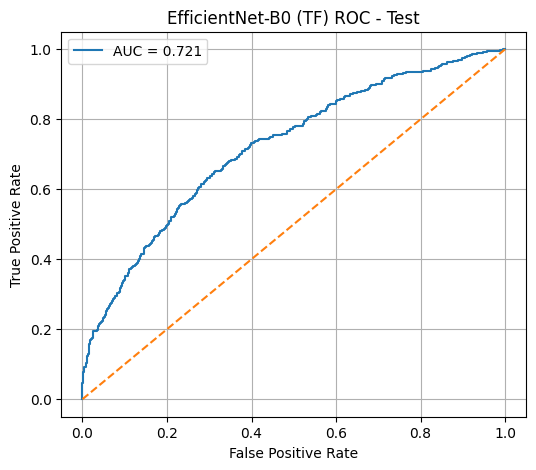

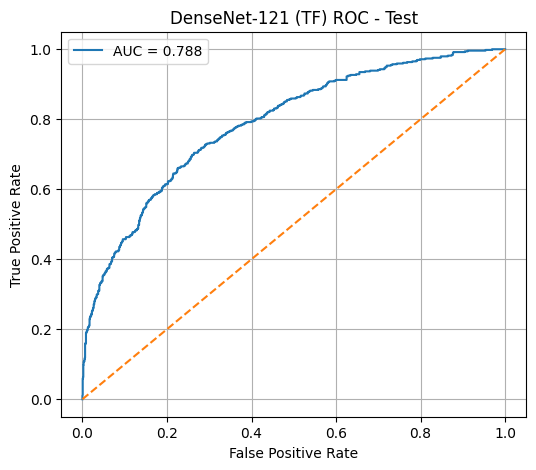

In [ ]:
# ROC Curves
def plot_roc(df, title):
    y_true = df["label"].values
    scores = df["score"].values

    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc(eff_test_results["df"],  "EfficientNet-B0 (TF) ROC - Test")
plot_roc(dense_test_results["df"], "DenseNet-121 (TF) ROC - Test")


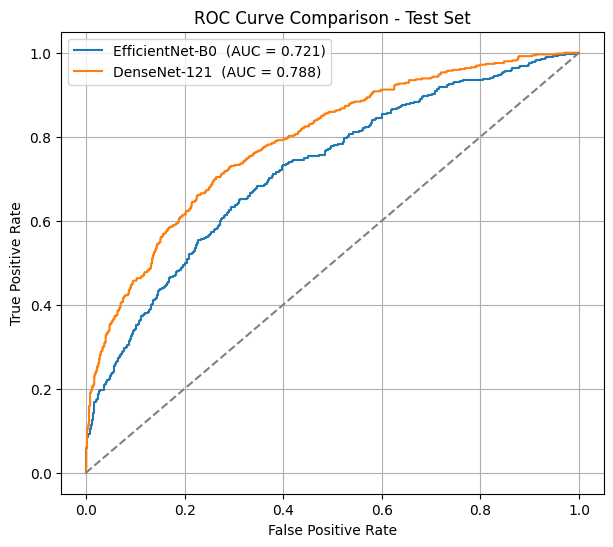

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_two_rocs(df1, df2, label1, label2, title):
    y_true1, scores1 = df1["label"].values, df1["score"].values
    y_true2, scores2 = df2["label"].values, df2["score"].values

    # ROC + AUC for model 1
    fpr1, tpr1, _ = roc_curve(y_true1, scores1)
    auc1 = roc_auc_score(y_true1, scores1)

    # ROC + AUC for model 2
    fpr2, tpr2, _ = roc_curve(y_true2, scores2)
    auc2 = roc_auc_score(y_true2, scores2)

    # Plot
    plt.figure(figsize=(7,6))
    plt.plot(fpr1, tpr1, label=f"{label1} (AUC = {auc1:.3f})")
    plt.plot(fpr2, tpr2, label=f"{label2} (AUC = {auc2:.3f})")

    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Use function
plot_two_rocs(
    eff_test_results["df"],
    dense_test_results["df"],
    "EfficientNet-B0 ",
    "DenseNet-121 ",
    "ROC Curve Comparison - Test Set"
)


# Bootstrap AUC Confidence Intervals

In [21]:
# %%
def bootstrap_auc_ci(y_true, scores, n_boot=1000, alpha=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true).astype(int)
    scores = np.asarray(scores).astype(float)
    n = len(y_true)

    aucs = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        try:
            aucs.append(roc_auc_score(y_true[idx], scores[idx]))
        except ValueError:
            continue

    aucs = np.array(aucs)
    mean_auc = aucs.mean()
    ci_low = np.percentile(aucs, 100 * alpha/2)
    ci_high = np.percentile(aucs, 100 * (1 - alpha/2))

    return float(mean_auc), float(ci_low), float(ci_high)


def compute_bootstrap_table(model_name, df):
    rows = []
    for group, mask in [
        ("Overall", np.ones(len(df), dtype=bool)),
        ("Female", df["gender"].values == 0),
        ("Male",   df["gender"].values == 1)
    ]:
        if mask.sum() == 0:
            continue

        y = df["label"].values[mask]
        s = df["score"].values[mask]

        mean_auc, low, high = bootstrap_auc_ci(y, s)

        rows.append({
            "Model": model_name,
            "Group": group,
            "AUC_mean": mean_auc,
            "AUC_CI_low": low,
            "AUC_CI_high": high,
            "N": int(mask.sum())
        })

    return pd.DataFrame(rows)

eff_bootstrap = compute_bootstrap_table("EfficientNet-B0 (TF)", eff_test_results["df"])
dense_bootstrap = compute_bootstrap_table("DenseNet-121 (TF)", dense_test_results["df"])

bootstrap_summary = pd.concat([eff_bootstrap, dense_bootstrap], ignore_index=True)
bootstrap_summary


,Model,Group,AUC_mean,AUC_CI_low,AUC_CI_high,N
0,EfficientNet-B0 (TF),Overall,0.721400,0.694782,0.747930,1914
1,EfficientNet-B0 (TF),Female,0.722312,0.681180,0.762494,880
2,EfficientNet-B0 (TF),Male,0.718615,0.684487,0.753172,1034
3,DenseNet-121 (TF),Overall,0.788782,0.766087,0.812446,1914
4,DenseNet-121 (TF),Female,0.776407,0.740568,0.811256,880
5,DenseNet-121 (TF),Male,0.799608,0.768368,0.829251,1034


# Final Results Summary

In [ ]:
# %Final Results Summary%
final_summary = {
    "efficientnet_b0_tf": eff_test_results,
    "densenet121_tf": dense_test_results,
    "bootstrap_auc": bootstrap_summary.to_dict(orient="records")
}

summary_path = os.path.join(RESULTS_DIR, "final_results_summary_tf.json")

# JSON-safe conversion
json_ready = {}
for k, v in final_summary.items():
    try:
        json_ready[k] = json.loads(json.dumps(v, default=str))
    except:
        json_ready[k] = str(v)

with open(summary_path, "w") as f:
    json.dump(json_ready, f, indent=4)

print("Saved final results summary to:", summary_path)


Saved final results summary to: ./results_odir_dr_tf\final_results_summary_tf.json


# Loss AUC Curve

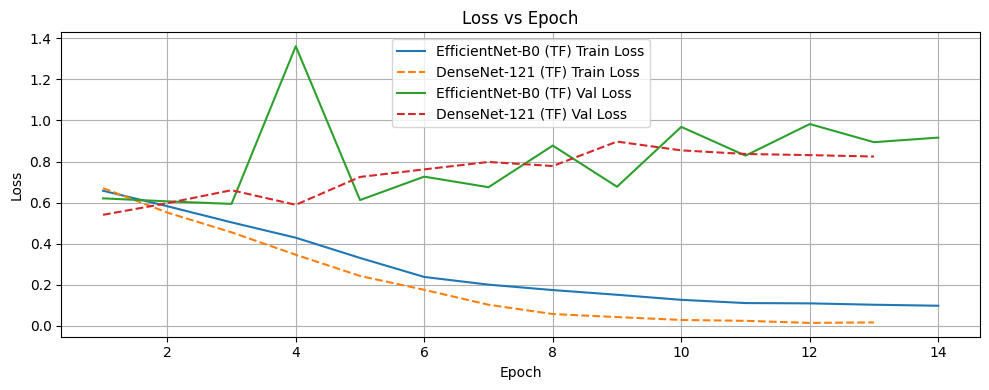

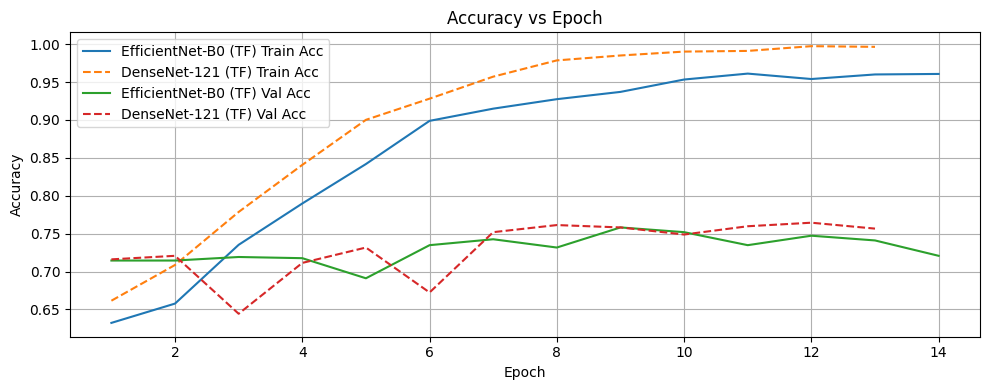

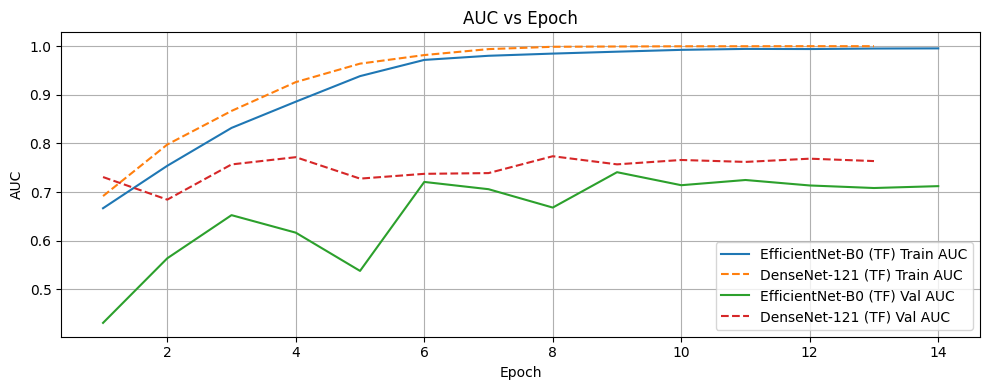

In [ ]:
# Loss AUC Curve
def plot_history_comparison(eff_history, dense_history, model_names=("EfficientNet-B0", "DenseNet-121")):
    """
    eff_history, dense_history: Keras History objects returned by model.fit
    """
    eff_hist = eff_history.history
    dense_hist = dense_history.history

    epochs_eff = range(1, len(eff_hist["loss"]) + 1)
    epochs_dense = range(1, len(dense_hist["loss"]) + 1)

    # --- 1. Loss ---
    plt.figure(figsize=(10, 4))
    # Train loss
    plt.plot(epochs_eff, eff_hist["loss"], label=f"{model_names[0]} Train Loss")
    plt.plot(epochs_dense, dense_hist["loss"], label=f"{model_names[1]} Train Loss", linestyle="--")
    # Val loss (if present)
    if "val_loss" in eff_hist and "val_loss" in dense_hist:
        plt.plot(epochs_eff, eff_hist["val_loss"], label=f"{model_names[0]} Val Loss")
        plt.plot(epochs_dense, dense_hist["val_loss"], label=f"{model_names[1]} Val Loss", linestyle="--")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 2. Accuracy (if available) ---
    acc_keys = ["accuracy", "val_accuracy"]
    if all(k in eff_hist for k in acc_keys) and all(k in dense_hist for k in acc_keys):
        plt.figure(figsize=(10, 4))
        # Train accuracy
        plt.plot(epochs_eff, eff_hist["accuracy"], label=f"{model_names[0]} Train Acc")
        plt.plot(epochs_dense, dense_hist["accuracy"], label=f"{model_names[1]} Train Acc", linestyle="--")
        # Val accuracy
        plt.plot(epochs_eff, eff_hist["val_accuracy"], label=f"{model_names[0]} Val Acc")
        plt.plot(epochs_dense, dense_hist["val_accuracy"], label=f"{model_names[1]} Val Acc", linestyle="--")

        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Epoch")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Accuracy metrics ('accuracy', 'val_accuracy') not found in history. "
              "Add BinaryAccuracy to model.compile(metrics=[...]) if you want these plots.")

    # --- 3. AUC ---
    if "auc" in eff_hist and "auc" in dense_hist:
        plt.figure(figsize=(10, 4))
        # Train AUC
        plt.plot(epochs_eff, eff_hist["auc"], label=f"{model_names[0]} Train AUC")
        plt.plot(epochs_dense, dense_hist["auc"], label=f"{model_names[1]} Train AUC", linestyle="--")
        # Val AUC (if present)
        if "val_auc" in eff_hist and "val_auc" in dense_hist:
            plt.plot(epochs_eff, eff_hist["val_auc"], label=f"{model_names[0]} Val AUC")
            plt.plot(epochs_dense, dense_hist["val_auc"], label=f"{model_names[1]} Val AUC", linestyle="--")

        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.title("AUC vs Epoch")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("AUC metrics ('auc', 'val_auc') not found in history. "
              "Make sure AUC is in model.compile(metrics=[...]).")


# Call this after both models are trained:
plot_history_comparison(eff_history, dense_history,
                        model_names=("EfficientNet-B0 (TF)", "DenseNet-121 (TF)"))


In [37]:
def plot_history_comparison_single(eff_history, dense_history,
                                   model_names=("EfficientNet-B0", "DenseNet-121")):
    """
    Plot Loss, Accuracy, and AUC for two models in a single figure with subplots.
    """
    eff_hist = eff_history.history
    dense_hist = dense_history.history

    epochs_eff = range(1, len(eff_hist["loss"]) + 1)
    epochs_dense = range(1, len(dense_hist["loss"]) + 1)

    # Determine how many subplots we need
    has_acc = "accuracy" in eff_hist and "accuracy" in dense_hist
    has_auc = "auc" in eff_hist and "auc" in dense_hist

    rows = 1 + has_acc + has_auc  # loss + (acc?) + (auc?)

    fig, axes = plt.subplots(rows, 1, figsize=(10, 4 * rows))
    if rows == 1:
        axes = [axes]  # ensure it's iterable

    idx = 0

    # ---------------------------
    # 1. LOSS subplot
    # ---------------------------
    ax = axes[idx]
    ax.plot(epochs_eff, eff_hist["loss"], label=f"{model_names[0]} Train Loss")
    ax.plot(epochs_dense, dense_hist["loss"], linestyle="--",
            label=f"{model_names[1]} Train Loss")

    if "val_loss" in eff_hist and "val_loss" in dense_hist:
        ax.plot(epochs_eff, eff_hist["val_loss"], label=f"{model_names[0]} Val Loss")
        ax.plot(epochs_dense, dense_hist["val_loss"], linestyle="--",
                label=f"{model_names[1]} Val Loss")

    ax.set_title("Loss vs Epoch")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()
    idx += 1

    # ---------------------------
    # 2. ACCURACY subplot
    # ---------------------------
    if has_acc:
        ax = axes[idx]
        ax.plot(epochs_eff, eff_hist["accuracy"], label=f"{model_names[0]} Train Acc")
        ax.plot(epochs_dense, dense_hist["accuracy"], linestyle="--",
                label=f"{model_names[1]} Train Acc")

        ax.plot(epochs_eff, eff_hist["val_accuracy"], label=f"{model_names[0]} Val Acc")
        ax.plot(epochs_dense, dense_hist["val_accuracy"], linestyle="--",
                label=f"{model_names[1]} Val Acc")

        ax.set_title("Accuracy vs Epoch")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.grid(True)
        ax.legend()
        idx += 1

    # ---------------------------
    # 3. AUC subplot
    # ---------------------------
    if has_auc:
        ax = axes[idx]
        ax.plot(epochs_eff, eff_hist["auc"], label=f"{model_names[0]} Train AUC")
        ax.plot(epochs_dense, dense_hist["auc"], linestyle="--",
                label=f"{model_names[1]} Train AUC")

        if "val_auc" in eff_hist and "val_auc" in dense_hist:
            ax.plot(epochs_eff, eff_hist["val_auc"], label=f"{model_names[0]} Val AUC")
            ax.plot(epochs_dense, dense_hist["val_auc"], linestyle="--",
                    label=f"{model_names[1]} Val AUC")

        ax.set_title("AUC vs Epoch")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("AUC")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


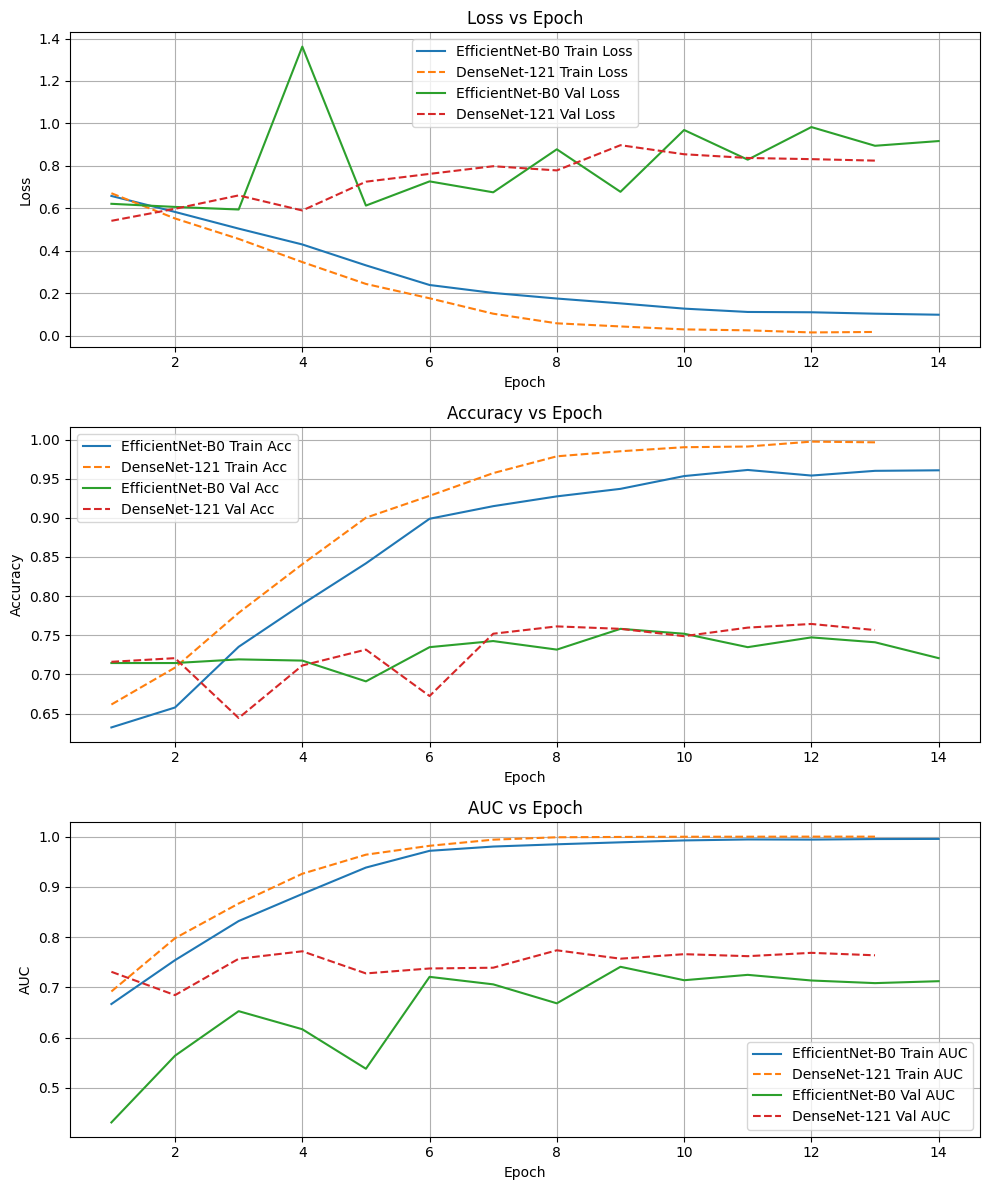

In [39]:
plot_history_comparison_single(
    eff_history,
    dense_history,
    model_names=("EfficientNet-B0", "DenseNet-121")
)
